Source: 
- https://github.com/wblachowski/bhmsds?fbclid=IwAR2WbJRLMxecP4a41iTjJR-_idug6anFvjFdz8XyinaZV7gA8OFwaah7MR8
- https://towardsdatascience.com/building-a-handwritten-multi-digit-calculator-f03cf5028052
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
- https://medium.com/ai-techsystems/handwritten-optical-character-recognition-calculator-using-cnn-and-deep-learning-fcc432f88b63
- https://www.youtube.com/watch?v=cVXfqGy4CUo
- https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://nextjournal.com/gkoehler/pytorch-mnist
- https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc
- https://medium.com/analytics-vidhya/from-keras-to-pytorch-722fa3b65cce
- http://ais.informatik.uni-freiburg.de/teaching/ss18/driving_lab/pytorch_example.py

In [6]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os 
import cv2
import pandas as pd 
import random 
import os, os.path
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchinfo import summary
import imutils


#use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#labels  
LABELS_DICT = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    'plus' : 10,
    'minus' : 11,
    'slash' : 12,
    'dot' : 13,
    'w' : 14,
    'x' : 15,
    'y' : 16,
    'z' : 17,
    }

INV_LABELS_DICS = {v: k for k, v in LABELS_DICT.items()}

In [2]:
"""
class Digits(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir

    #function to resize image to same dimensions 
    def convert(self, img_path):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   #from BGR to RGB
        _ , image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        image = cv2.resize(image, (28, 28))
        
        return image

    #function to get image label
    def get_label(self, filename):
        label_name = filename.split("-")
        label = LABELS_DICT[label_name[0]]

        return label


    def __len__(self):
        return len(os.listdir(self.img_dir))


    def __getitem__(self, idx):
        #getting image path
        filename = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        #get image and corresponding label
        label = self.get_label(filename)
        image = self.convert(img_path)
        
        #converting to tensor 
        img_tensor = torch.from_numpy(image)
        img_tensor = img_tensor.permute(2, 0, 1)

        return img_tensor, label
"""

'\nclass Digits(Dataset):\n    def __init__(self, img_dir):\n        self.img_dir = img_dir\n\n    #function to resize image to same dimensions \n    def convert(self, img_path):\n        image = cv2.imread(img_path)\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   #from BGR to RGB\n        _ , image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)\n        image = cv2.resize(image, (28, 28))\n        \n        return image\n\n    #function to get image label\n    def get_label(self, filename):\n        label_name = filename.split("-")\n        label = LABELS_DICT[label_name[0]]\n\n        return label\n\n\n    def __len__(self):\n        return len(os.listdir(self.img_dir))\n\n\n    def __getitem__(self, idx):\n        #getting image path\n        filename = os.listdir(self.img_dir)[idx]\n        img_path = os.path.join(self.img_dir, filename)\n        \n        #get image and corresponding label\n        label = self.get_label(filename)\n        image = self.convert(img_p

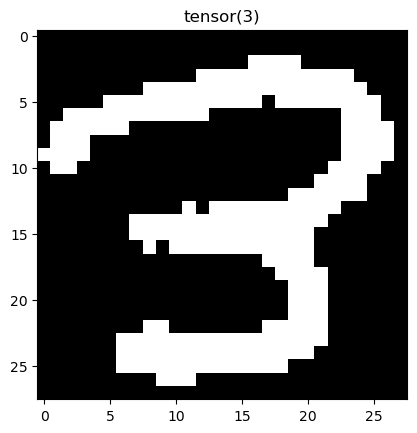

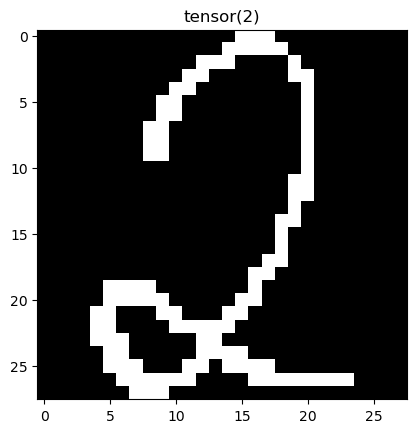

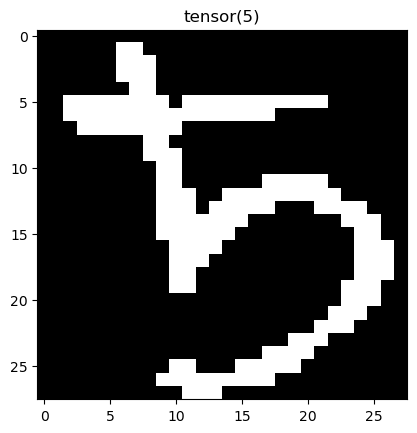

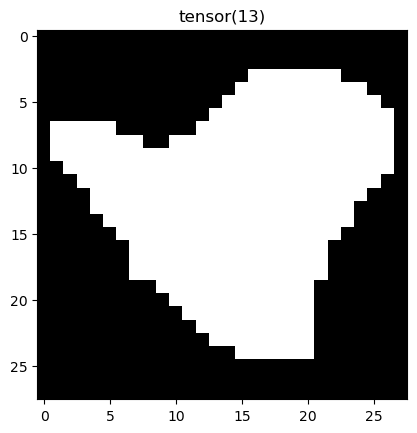

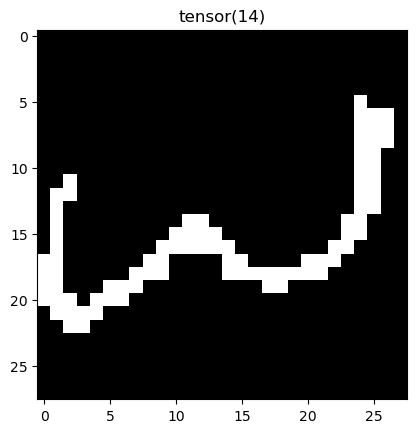

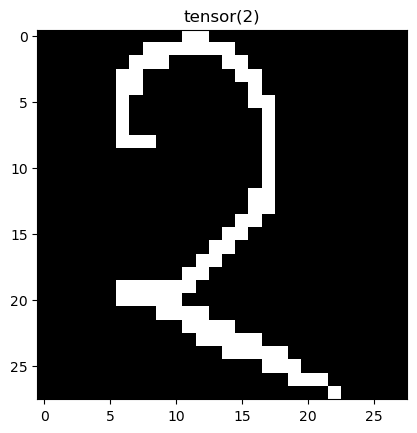

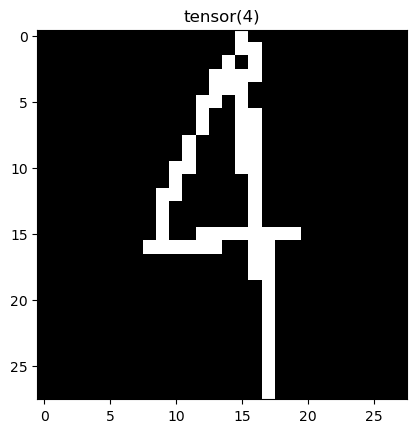

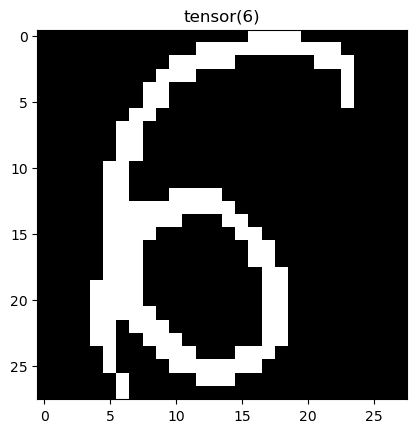

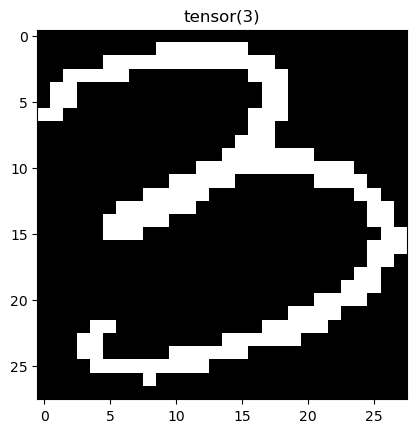

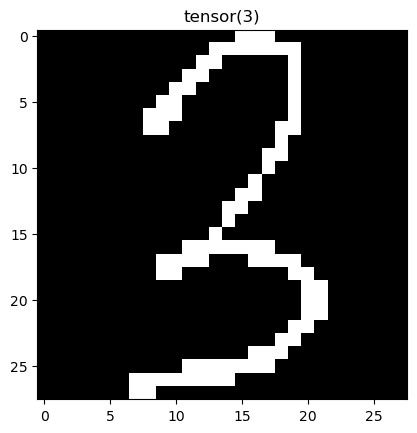

In [7]:
"""
CREATING CUSTOM DATASET
Data consist of: 
- Numbers from 1-9
- Operators: +, -, / and * 
- Letters: w, x, y, z

- Format of each image: <symbol-name>-<id>.png
- 1500 images of each type 
"""

class Digits(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    #function to resize image to same dimensions 
    def convert(self, img_path):
        image = cv2.imread(img_path)
        #image = cv2.resize(image, (32, 32))      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting from bgr to grayscale for faster computation 
        _ , image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        if self.transform:
            image = self.transform(image) 

            """
            print("Normal:", torch.mean(image))
            print("Normal:", torch.std(image))
            print("Normal:",torch.var(image))
            """

            #normalizing tensor
            mean, std = torch.mean(image), torch.std(image)
            normalize = transforms.Normalize(mean, std)
            image = normalize(image)

            """       
            print("Normalised:", torch.mean(image))
            print("Normalised:", torch.std(image))
            print("Normalised:",torch.var(image))
            """
        return image

    #function to get image label
    def get_label(self, filename):
        label_name = filename.split("-")
        label = LABELS_DICT[label_name[0]]

        if self.target_transform:
            label = self.target_transform(label)
        
        return label

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        #getting image path
        filename = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        #get image and corresponding label
        label = self.get_label(filename)
        image = self.convert(img_path)
        
        return image, label
    


#set up dataset
transform = transforms.Compose([transforms.ToTensor()]) #normalizing data
#target_transform = transforms.Compose([lambda x: torch.tensor([x]), 
#                                        lambda x: torch.nn.functional.one_hot(x, num_classes=len(LABELS_DICT))]) 

dataset = Digits("data/symbols/", transform=transform)

datasetSize = dataset.__len__()
batch_size = 2 

#split data: 80% training, 10% validation, 10% test
test_train_data, test_validation_data, test_test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])

#creating data loaders
test_trainloader = DataLoader(test_train_data, batch_size=batch_size, shuffle=True, num_workers=0)


"""
GETTING SOME IMAGES FROM DATASET 
"""
dataiter = iter(test_trainloader)
images, labels = dataiter.next()

#run through 3 batches
for i in range(5): #Run through 5 batches
    images, labels = dataiter.next()
    for image, label in zip(images, labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(label)


In [8]:
"""
PREPARING DATA FOR TRAINING
"""
#normalizing data and one-hot encode
transform = transforms.Compose([transforms.ToTensor()])  

#create data
dataset = Digits("data/symbols/", transform=transform)
datasetSize = dataset.__len__()

batch_size = 64 

#split data: 80% training, 10% validation, 10% test
train_data, validation_data, test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])
#train_data, validation_data, test_data = random_split(dataset, [6500, 500, 20000])

#creating data loaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validateloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [9]:
"""
NETWORK

CNN network 
Hyperparameters:
- Kernel size
- Pooling size
- Number of filters/layers
- Epochs 
- Dropout
- Number of neurons 
- Connectivity between patterns 
- Batch size
- Learning rate

Source: https://www.researchgate.net/figure/List-of-key-hyperparameters-related-to-CNN-design_tbl1_333159463

"""
class Network(nn.Module):
    def __init__(self, num_classes):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same', bias=True)      #since image has been converted to grayscale, then the image has 1 input feature 
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding="same", bias=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same", bias=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.conv2_drop = nn.Dropout2d()                                                        #dropout - to avoid overfitting
        self.fc1 = nn.Linear(64 * 3 * 3, 120)                                                   #image becomes 64 * 3 * 3 after flatting 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    
    def forward(self, x):
        x = self.conv1(x)   #[batch size, 32, 28, 28]
        x = self.pool1(x)   #[batch size, 32, 14, 14]
        x = F.relu(x)
        x = self.conv2(x)   #[batch size, 32, 28, 28]
        x = self.pool2(x)   #[batch size, 32, 7, 7]
        x = F.relu(x)
        x = self.conv3(x)   #[batch size, 64, 7, 7]
        x = self.pool3(x)   #[batch size, 64, 3, 3]
        x = F.relu(x)
        x = self.flatten(x) #[batch size, 64 * 3 * 3]
        x = self.conv2_drop(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


#testing forward call 
testNetwork = Network(len(LABELS_DICT)).to(device)
print(summary(testNetwork, (1, 1, 28, 28)))

"""
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

print(len(example_data))
print(example_data.shape)
"""

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 18]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 14, 14]           9,248
├─MaxPool2d: 1-4                         [1, 32, 7, 7]             --
├─Conv2d: 1-5                            [1, 64, 7, 7]             18,496
├─MaxPool2d: 1-6                         [1, 64, 3, 3]             --
├─Flatten: 1-7                           [1, 576]                  --
├─Dropout2d: 1-8                         [1, 576]                  --
├─Linear: 1-9                            [1, 120]                  69,240
├─Linear: 1-10                           [1, 84]                   10,164
├─Linear: 1-11                           [1, 18]                   1,530
Total params: 108,998
Trainable params: 108,998
Non-trainable para

'\nexamples = enumerate(trainloader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nprint(len(example_data))\nprint(example_data.shape)\n'

In [10]:
"""
TRAINING METHOD
"""
#lists to hold accuracy and loss - used for plotting 
training_losses = []
training_accuracy = []

def train(network, trainloader, optimizer, criterion, device):
    #variables accuracy and loss 
    size, batch_size = 0, 0
    training_correct, correct = 0, 0 

    #setting network to training mode 
    network.to(device)
    network.train()
    
    #training the model
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        print(batch_idx)
        
        #calculate predictions and loss
        output = network(data)
        loss = criterion(output, target)

        #backpropagate
        optimizer.zero_grad()   #1. sets gradients to zero
        loss.backward()         #2. compute new gradients using back propagation
        optimizer.step()        #3. update parameters with new gradients 

        #computing accuracy 
        correct = (output.argmax(1) == target).type(torch.float).sum().item()
        training_correct += correct
        batch_size = len(data)

        #storing loss 
        training_losses.append(loss.item())
        training_accuracy.append(correct / batch_size)

        #updating size
        size += batch_size
        
        #print out loss data
        if(batch_idx % 100 == 0):
            print("[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(batch_idx * len(data),
                                                            len(trainloader.dataset),
                                                            100. * batch_idx / len(trainloader), 
                                                            loss.item()))
    #save internal state
    torch.save(network.state_dict(), "model.pth")
    torch.save(optimizer.state_dict(), "optimizer.pth")

    #print training accuracy 
    training_correct = training_correct / size 

    print(f"Training accuracy: {(100 * training_correct):>0.1f}%")
    

In [11]:
"""
VALIDATION METHOD
"""
#lists to hold accuracy and loss - used for plotting 
validate_losses = []
validate_accuracy = []


def validate(network, validationloader, criterion, device):
    #variables
    size, batch_size = 0, 0
    validation_loss, loss = 0, 0
    validation_correct, correct = 0, 0

    num_batches = len(validationloader)

    #set network to testing mode
    network.to(device)
    network.eval()

    #validating the model 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validationloader):
            data, target = data.to(device), target.to(device)

            #getting batch size 
            batch_size = len(data)

            #predicting the output 
            output = network(data)

            #loss 
            loss = criterion(output, target)
            validation_loss += loss.item()
            validate_losses.append(loss.item())

            #accuracy
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            validation_correct += correct
            validate_accuracy.append(correct / batch_size)

            #updating size
            size += batch_size
        
    #calculate loss 
    validation_loss = validation_loss / num_batches

    #calculate accuracy   
    validation_correct = validation_correct / size

    #printing output of validation  
    print(f"Validation set: \n Accuracy: {(100 * validation_correct):>0.1f}%, Average loss: {validation_loss:>8f} \n")

In [12]:
"""
TRAINING AND VALIDATING  
"""
#hyperparameters 
epochs = 5
continue_epochs = 2
learning_rate = 0.01
momentum = 0.5

num_classes = len(LABELS_DICT)

#instance of network model 
network = Network(num_classes=num_classes)

#optimizer and loss function 
criterion = nn.functional.cross_entropy   #default loss function for multi-class classifications problems         
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)


#training and validating the model
for iEpoch in range(epochs): 
    print(f"Epoch {iEpoch + 1}\n--------------------")

    train(network, trainloader, optimizer, criterion, device)
    validate(network, validateloader, criterion, device)


Epoch 1
--------------------


KeyboardInterrupt: 

In [13]:
"""
TESTING
"""
#probably remove these two lists 
test_losses = []
test_accuracy = []

def evaluate(network, testloader, criterion, device):    
    test_loss, loss = 0, 0
    test_correct, correct = 0, 0

    #switching to eval mode 
    network.to(device)
    network.eval()

    #testing the model
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)

            #predicting output using model 
            output = network(data)
            predicted_label = output.cpu().data.max(1, keepdim=True)[1].item() 
        
            #update loss
            loss = criterion(output, target)
            test_loss += loss.item()
            #test_losses.append(loss.item())

            #calculate correct 
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            test_correct += correct
            #test_accuracy.append(correct)

            #randomly show test image and prediction  
            if (random.randint(0, 100) == 25):
                test_image = data.cpu().data.squeeze().numpy()
                test_image = cv2.resize(test_image, (800, 800))
                cv2.imshow("Test image", test_image)
                print("Target label: ", target.cpu().item())
                print("Predicted label: ", predicted_label)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

    
    #calculate average loss
    test_loss = test_loss / len(testloader.dataset)
    
    #printing 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                                test_correct, 
                                                                                len(testloader.dataset), 
                                                                                100. * test_correct / len(testloader.dataset)))

#getting previous internal state of model 
model = Network(num_classes=num_classes)
model.load_state_dict(torch.load("model.pth"))

#testing the model
evaluate(model, testloader, criterion, device)



Target label:  15
Predicted label:  15
Target label:  9
Predicted label:  9
Target label:  3
Predicted label:  3
Target label:  4
Predicted label:  4
Target label:  6
Predicted label:  6
Target label:  6
Predicted label:  6
Target label:  2
Predicted label:  2
Target label:  1
Predicted label:  1
Target label:  4
Predicted label:  4
Target label:  12
Predicted label:  12
Target label:  9
Predicted label:  9
Target label:  6
Predicted label:  6
Target label:  13
Predicted label:  13
Target label:  13
Predicted label:  13
Target label:  9
Predicted label:  9
Target label:  13
Predicted label:  13
Target label:  15
Predicted label:  15
Target label:  12
Predicted label:  12

Test set: Average loss: 0.1250, Accuracy: 2588.0/2700 (96%)



Text(0, 0.5, 'Test Loss')

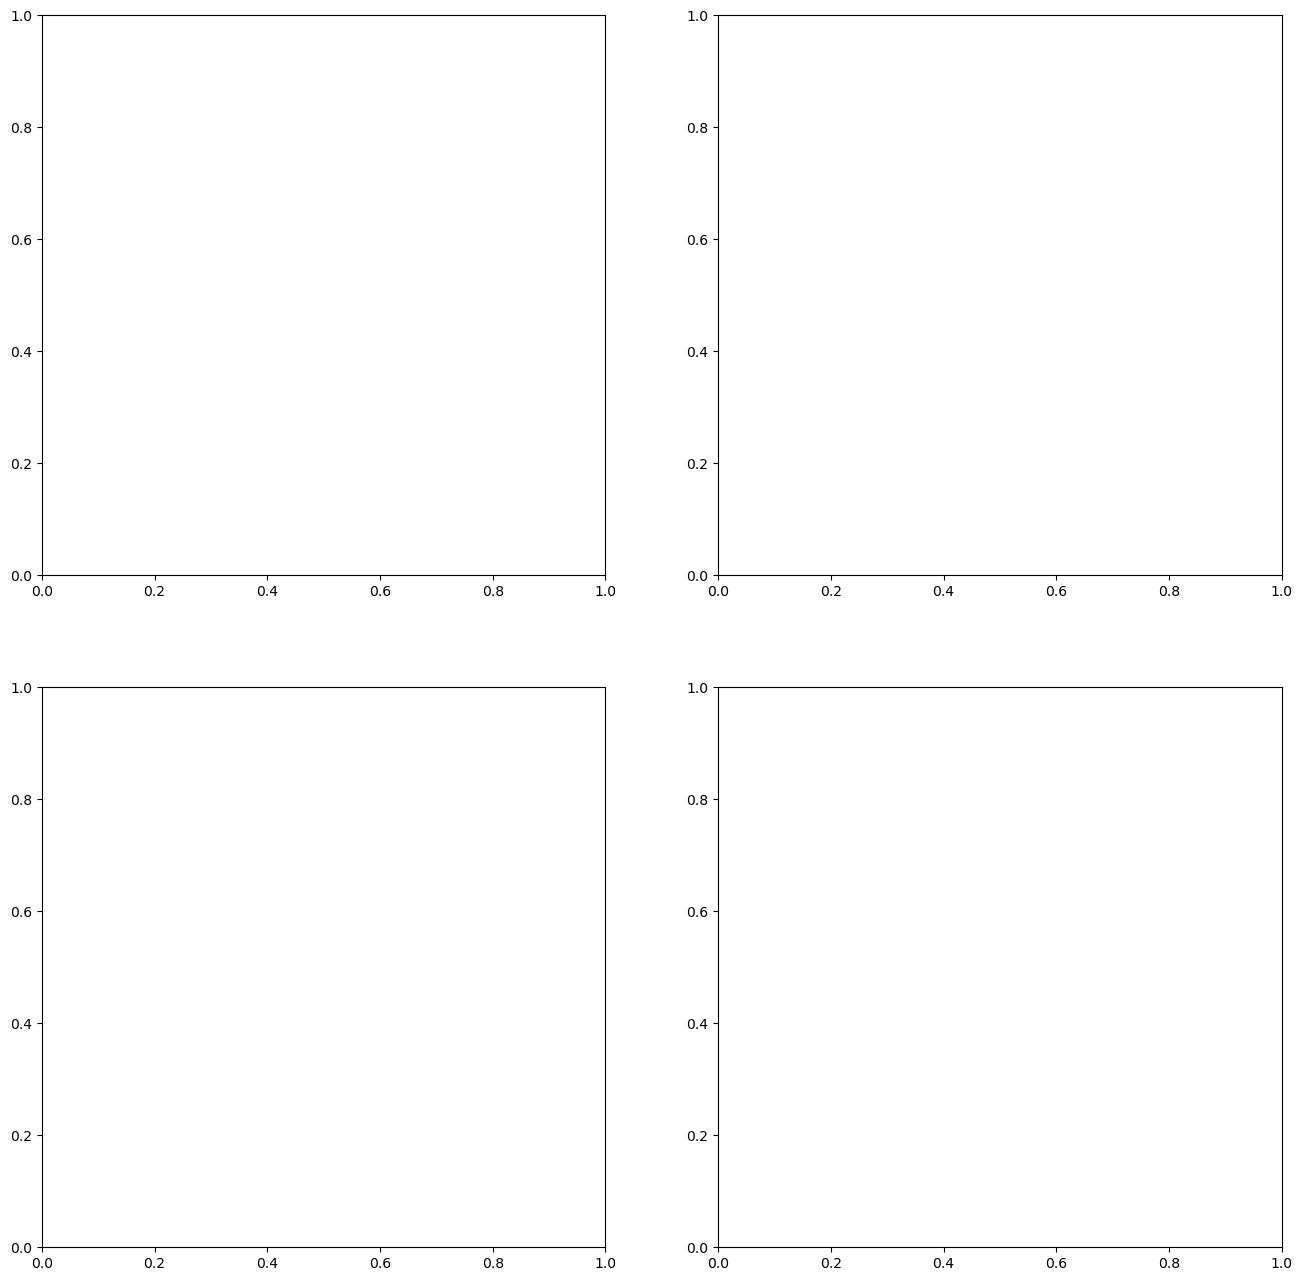

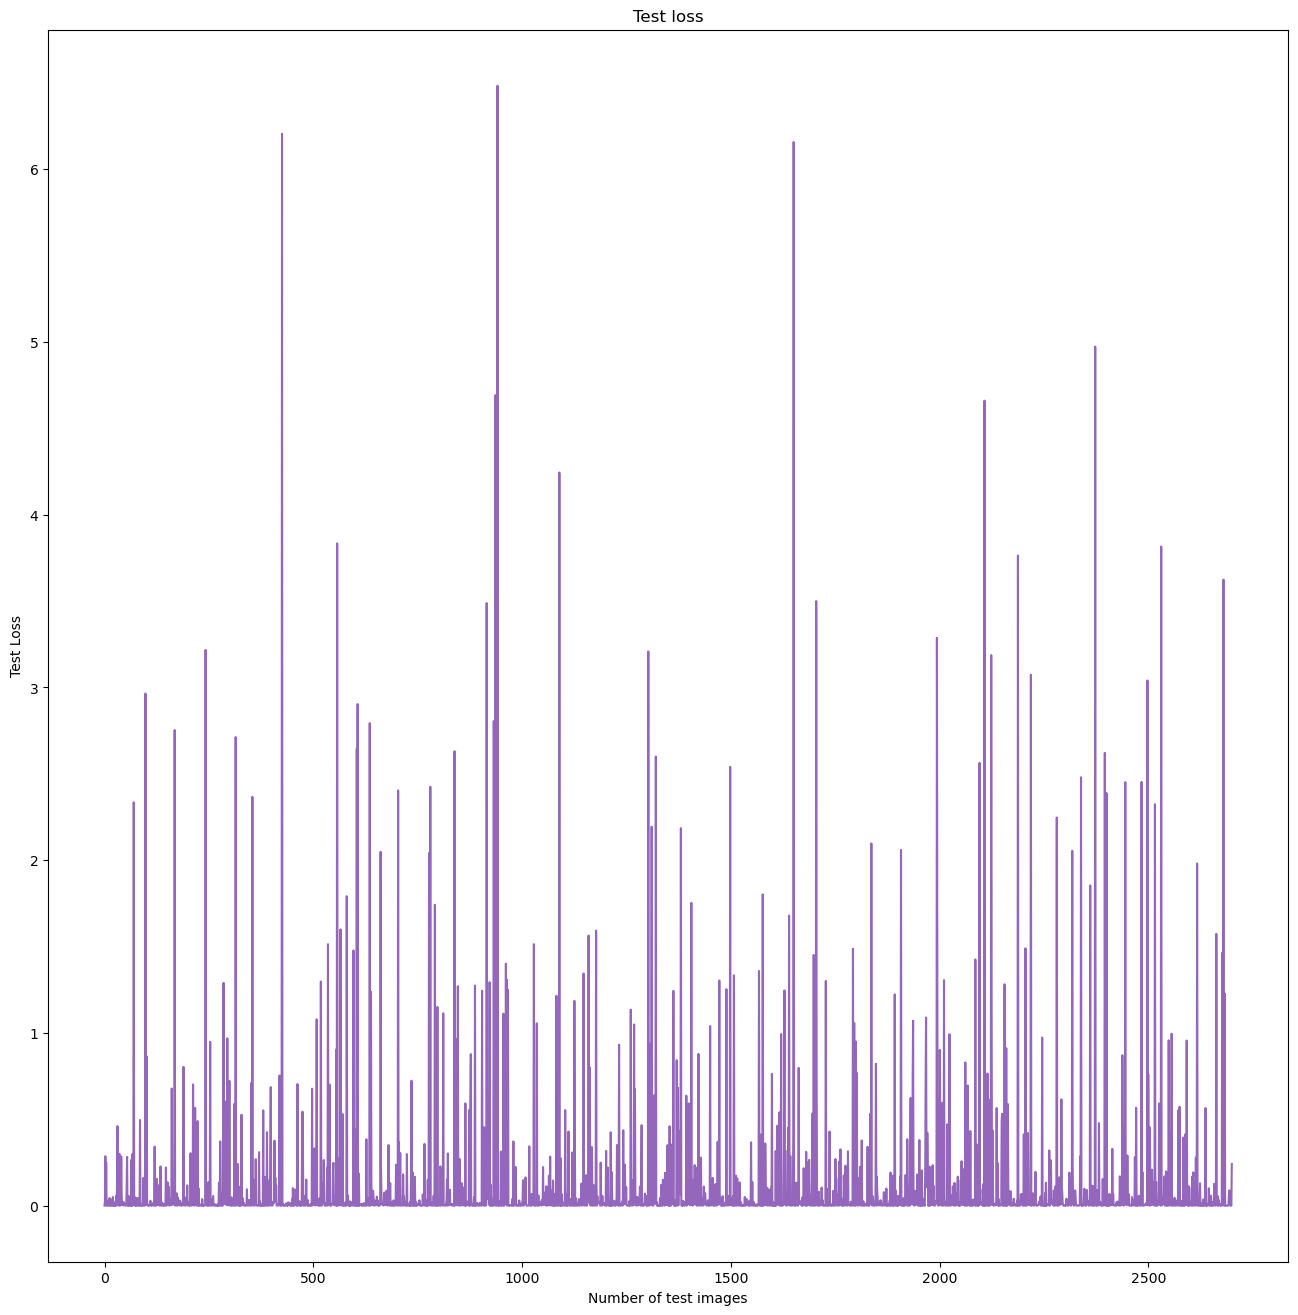

In [28]:

"""
PLOTTING RESULTS
"""
figure = plt.figure(figsize=(16, 16))
test_figure = plt.figure(figsize=(16,16))
 
epochs_training = np.linspace(0, epochs, len(training_accuracy))
epochs_validation = np.linspace(0, epochs, len(validate_accuracy))
n_test_images = np.linspace(0, len(test_data), len(test_data))


#training accuracy
figure.add_subplot(2, 2, 1)
plt.plot(epochs_training, training_accuracy)
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

#training loss
figure.add_subplot(2, 2, 2)
plt.plot(epochs_training, training_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")


#validation accuracy 
figure.add_subplot(2, 2, 3)
plt.plot(epochs_validation, validate_accuracy)
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")


#validation loss
figure.add_subplot(2, 2, 4)
plt.plot(epochs_validation, validate_losses)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")


In [14]:
"""
Helper functions
"""
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
  
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
  
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
  
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
  
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


#function to convert image to tensor 
def convert_to_tensor(image):
    image = cv2.resize(image, (28, 28))      

    #transform to tensor 
    trans = transforms.Compose([transforms.ToTensor()])
    tensor_image = trans(image)

    #normalizing tensor
    mean, std = torch.mean(tensor_image), torch.std(tensor_image)
    normalize = transforms.Normalize(mean, std)
    tensor_image = normalize(tensor_image)

    return tensor_image

    

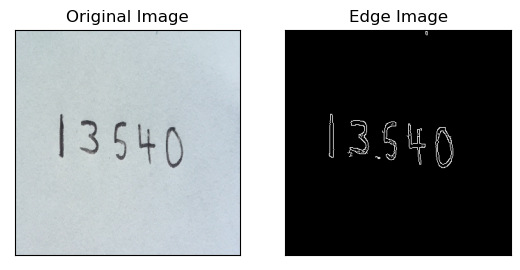

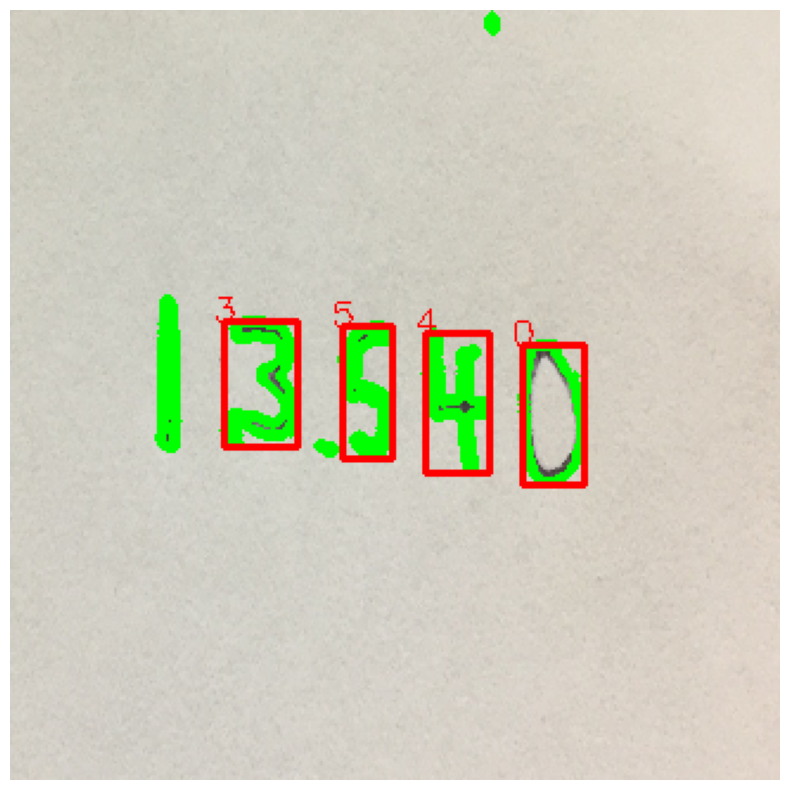

In [15]:
"""
TEST IMAGE ON EXPRESSION
"""
def pipeline_expression(image_path, network):
    #predictions 
    predictions = []

    #set up network
    network.to(device)
    network.eval()
    
    #process main image 
    image = cv2.imread(image_path)
    image = cv2.resize(image,(325, 325))                    #resize expression image
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    #grayscale image 
    edged = cv2.Canny(image_gray, 30, 150)                  #detect edges (min val: 30, max val: 150 - maybe change later?)

    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   #detecting contours 
    contours = imutils.grab_contours(contours)                                              #only getting the contours
    contours = sort_contours(contours, method="left-to-right")[0]                           #sorting from left to right


    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edged, cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
     
    #plot contours
    cv2.drawContours(image, contours, -1, (0,255,0), 3)
    cv2.imshow("title", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    
    with torch.no_grad():
        #converting contour -> image -> tensor
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)  #getting bounding boxes

            #determining the dimensions of the padded image 
            if 20 <= w and 30 <= h:
                roi = image_gray[y:y+h, x:x+w]
                thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                (th, tw) = thresh.shape

                if tw > th:
                    thresh = imutils.resize(thresh, width=32)

                if th > tw:
                    thresh = imutils.resize(thresh, height=32)
                
                (th, tw) = thresh.shape

                dx = int(max(0, 32 - tw) / 2.0)
                dy = int(max(0, 32 - th) / 2.0)

                #creates border around image - output is an image
                padded_image = cv2.copyMakeBorder(thresh, 
                                                top=dy, 
                                                bottom=dy, 
                                                left=dx, 
                                                right=dx, 
                                                borderType=cv2.BORDER_CONSTANT, 
                                                value=(0, 0, 0))
                
            
                #prints padded images 
                cv2.imshow("Padded", padded_image)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
                

                #convert images to tensors
                tensor_image = convert_to_tensor(padded_image)  #image dimensions: [1, 28, 28]
                tensor_image = tensor_image.unsqueeze(0)        #image dimensions: [1, 1, 28, 28]
                tensor_image = tensor_image.to(device)
                
                #predict output
                output = network(tensor_image)
                predicted_label = output.data.max(1, keepdim=True)[1].item()

                #convert and store
                label = INV_LABELS_DICS[predicted_label]
                predictions.append(label)

                #add rectangles and prediction to the image
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(image, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
    
    #printing image with bounding boxes
    figure = plt.figure(figsize=(10,10))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    return predictions
    

"""
Testing the pipeline
"""
#getting previous internal state of model 
model = Network(num_classes=num_classes)
model.load_state_dict(torch.load("model.pth"))


test_image_path = "test_images/test.jpg"
predictions = pipeline_expression(test_image_path, model)


In [16]:
"""
CALCULATOR METHOD
"""
def calculator(predictions):
    #final expression
    e = ""

    for i in predictions:
        if i == 'plus':
            e += '+'
        
        elif i == 'minus':
            e += '-'
        
        elif i == 'slash':
            e += '/'
        
        elif i == 'dot':
            e += '*'
        
        else:
            e += i
    
    #calculating the result 
    result = eval(e)
    print("Expression: ", e)
    print("Result: ", result)

calculator(predictions)


Expression:  3540
Result:  3540


Problems:
- Dataset has been written by few people. Thus, the model has been trained on similar data i.e same handwriting. This could be troublesome for people with significantly different handwriting 
- Cannot detect if "1" is just written as a line 
- Correct bounding box detection is dependent of image size
- Not 100% accuracy 
- No parenthesis / lacl of symbols

Questions:
- 3D input -> 2DDropout   
- Change batch size? 
- Add bias?

TODO
- Knowledge distiliation 
- Optimization strategies
- Weight initialization 
- Maybe implement confusion matrix to check performance 
- Implement letters x, y, z, and w in calculator method 
- Other performance metrics (see slides from week 11)
- Get data from different implementations of the model for comparison